In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, MCMC, Predictive
from pyro.infer.mcmc import NUTS

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from src import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader
from modules.mcmc_bnn import BayesianNN, NormalPrior, GaussianLikelihood, MCMC_BNN

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -2.445995590283073 - 2.2643438832509464
In Domain: (-10, 10)
Y-space: -2.292038921098926 - 2.1208595881462915
Out Domain: (-20, 20)
Y-space: -1.9804489444429034 - 2.5027454880659974


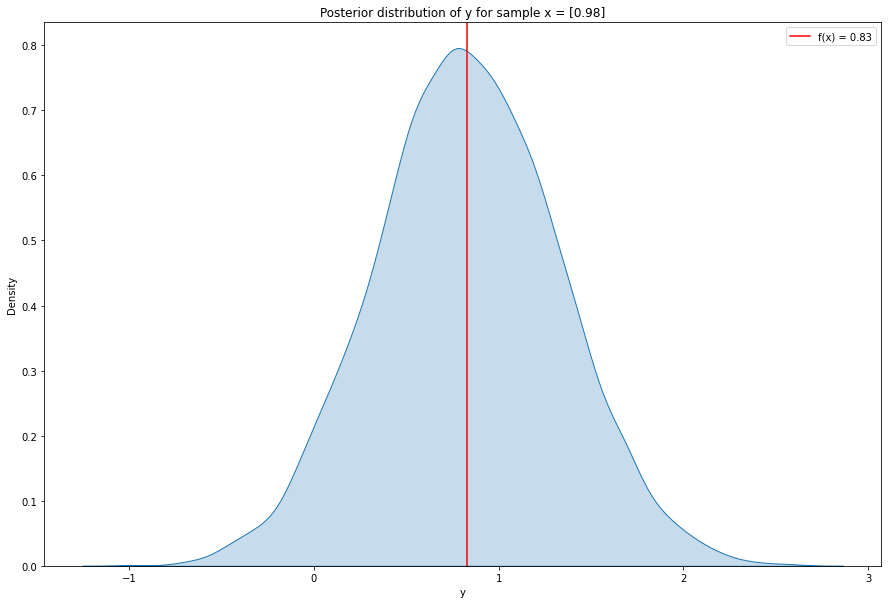

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

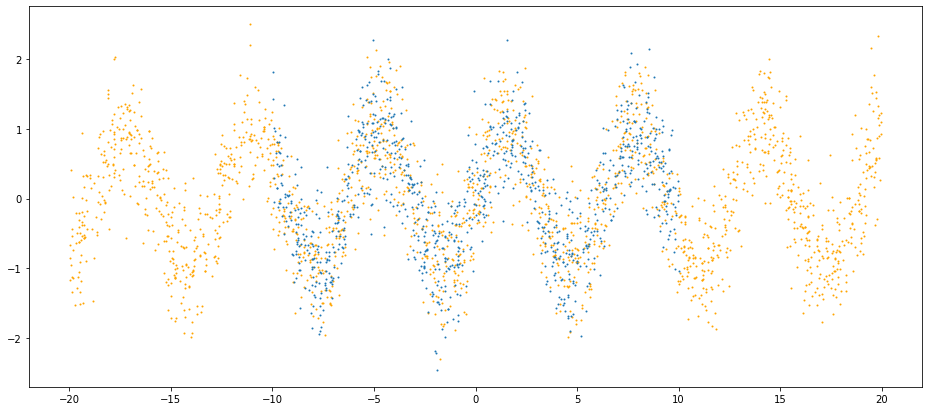

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
prior = NormalPrior(0, 1)
likelihood = GaussianLikelihood(0.1, len(x_train))
model = BayesianNN(1, 1, prior, hidden_features=[32], device="cpu")
model

BayesianNN(
  (fc0): BayesianLayer(
    (linear): PyroLinear(in_features=1, out_features=20, bias=True)
  )
  (act0): ReLU()
  (fc1): BayesianLayer(
    (linear): PyroLinear(in_features=20, out_features=1, bias=True)
  )
)

In [12]:
kernel_builder = NUTS
mcmc_bnn = MCMC_BNN(model, likelihood, kernel_builder, device="cpu")

In [13]:
mcmc_bnn.fit(train_dataloader, num_samples=300, num_warmup=100, num_chains=3)

Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/400 [00:00, ?it/s]

In [14]:
x_samps = x_test[:5]
preds = mcmc_bnn.predict(x_samps, num_predictions=100, aggregate=False)

In [15]:
preds.mean(dim=0)

tensor([[ 0.6554],
        [-0.2125],
        [ 0.2879],
        [-0.7742],
        [-1.0872]])

In [16]:
raise Exception("Stop here")

Exception: Stop here

In [17]:
train_sort = torch.argsort(x_train.squeeze())
preds = mcmc_bnn.predict(x_train[train_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

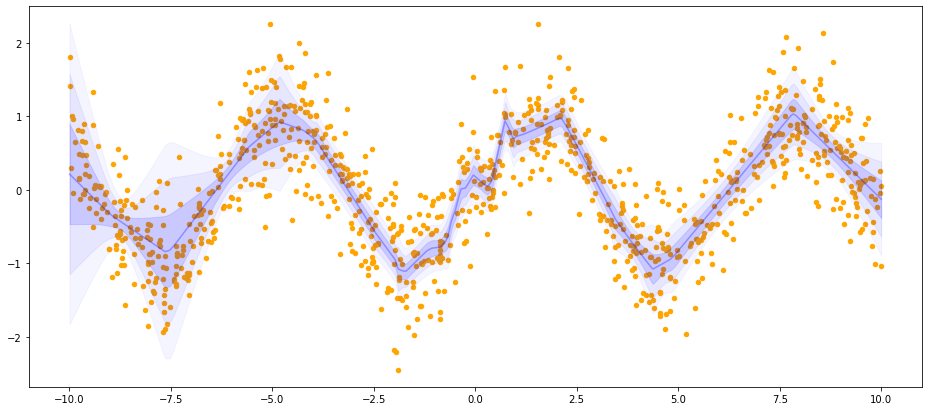

In [18]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [19]:
test_sort = torch.argsort(x_test.squeeze())
preds = mcmc_bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

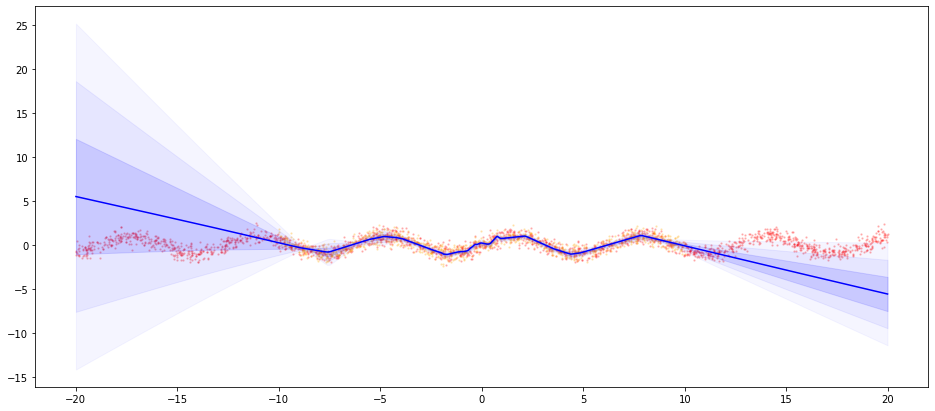

In [20]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

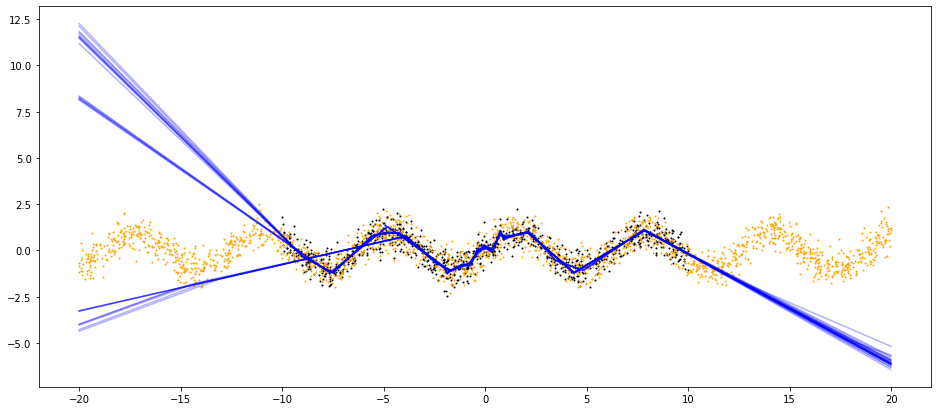

In [21]:


sampled_predictions = mcmc_bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [22]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

NameError: name 'bnn' is not defined